# **DATASET : Accelerometer, Gyroscope, and Magnetometer Sensors based Data for Recognizing Handwritten Digits**

**Made By: Ubiquitous Project Group 01**


*   Abhigyan Srivastava, 18064001
*   Aman Singh, 18085008
*   Piyush Singh, 18085045
*   Prateek Chaturvedi, 18085085





***Made on Google Colaboratory***

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn import svm
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
%matplotlib inline

### Packages for making the CNN Model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical 

np.random.seed(2)
random_seed = 2

# **Preprocessing of Raw Data**

We made **5 datasets** from the given raw dataset: 4 datsets (*train0, train1, train2, train3*) for the Federated Learning training and 1 dataset (*test*) for predictions

---

Please refer to the Project Report for a better understanding

In [ ]:
import random

li = []
for i in range(1, 51):
  li.append(i)

random.shuffle(li) #list of all numbers between 1 & 50 in random order

path = "/content/drive/MyDrive/Colab Notebooks/Ubi Projects/Handwritten Digits Data/"
savingPath = "/content/drive/MyDrive/Colab Notebooks/Ubi Projects/train"

headers = ["AccX", "AccY",	"AccZ",	"GyrX",	"GyrY",	"GyrZ",	"MagX",	"MagY",	"MagZ"]

test = pd.DataFrame()

for i in range(0, 4):
  train = pd.DataFrame()
  for j in range(1, 6):
    P = i*5 + j
    for D in range(10):
      for rd in range(0, 40):
        tot = path + "P" + str(P) + "/D" + str(D) + "/" + str(li[rd]) + "_D" + str(D) + ".csv"
        print(tot)
        tmp = pd.read_csv(tot)
        siz = tmp.shape[0]
        r = 100-siz%100
        df = pd.DataFrame()
        for k in range(9):
          cnt = 0
          id = 0
          while(cnt < siz):
            df["x" + str(id*9 + k)] = [tmp[headers[k]][cnt]]
            cnt = cnt + siz//100+(id >= r)
            id = id+1
        df["Output"] = [D]
        train = train.append(df)
      for rd in range(40, 50):
        tot = path + "P" + str(P) + "/D" + str(D) + "/" + str(li[rd]) + "_D" + str(D) + ".csv"
        print(tot) 
        tmp = pd.read_csv(tot)
        siz = tmp.shape[0]
        r = 100-siz%100
        df = pd.DataFrame()
        for k in range(9):
          cnt = 0
          id = 0
          while(cnt < siz):
            df["x" + str(id*9 + k)] = [tmp[headers[k]][cnt]]
            cnt = cnt + siz//100+(id >= r)
            id = id+1
        df["Output"] = [D]
        test = test.append(df)
  train.to_csv(savingPath + str(i) + ".csv", index=False)

test.to_csv("/content/drive/MyDrive/Colab Notebooks/Ubi Projects/test.csv", index=False)


# **Building a Neural Network model**

**Model Architecture**

In [ ]:
def get_model():
  model = Sequential()
  model.add(Dense(300, input_shape=(900,), activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax')) #10 Possible Outcomes, i.e., 0,1,2,...,9.

  adam = Adam(lr=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  return model;

In [ ]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               270300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 301,410
Trainable params: 301,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tr_models = list() # to store the models for each training dataset
trhist = [[],[],[],[]]
vlhist = [[],[],[],[]] 

**Function for fitting every model to its training dataset**

In [ ]:
def Split_And_Train(file, weights):
  train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Ubi Projects/train" + str(file) + ".csv")

  Y_train = train['Output']
  X_train = train.drop(labels="Output", axis = 1)
  Y_train = to_categorical(Y_train, num_classes=10)
  X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=random_seed)

  model = get_model()
  model.set_weights(weights)
  chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
  hist = model.fit(X_train, Y_train, epochs=25, batch_size=100, callbacks=[chk], validation_data=(X_val, Y_val))

  trhist[file]=hist.history['accuracy']
  vlhist[file]=hist.history['val_accuracy']
    
  return model.get_weights()


# **Predicting and Evaluation**

In [ ]:
net_weight = get_model().get_weights()
weight0 = net_weight
weight1 = net_weight
weight2 = net_weight
weight3 = net_weight

test_acc = list() # for recording the test accuracy 

while(True):
  weight0 = Split_And_Train(0, net_weight)
  weight1 = Split_And_Train(1, net_weight)
  weight2 = Split_And_Train(2, net_weight)
  weight3 = Split_And_Train(3, net_weight)

  net_weight = (np.array(weight0) + np.array(weight1) + np.array(weight2) + np.array(weight3))/4

  test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Ubi Projects/test.csv")
  Y_test = test['Output']
  X_test = test.drop(labels="Output", axis = 1)

  model = get_model()
  model.set_weights(net_weight)
  test_pred = model.predict_classes(X_test)

  accuracy = accuracy_score(Y_test, test_pred)
  print("Hey! Answer is about to come so please watch carefully that what the accuracy comes")
  print(accuracy)
  test_acc.append(accuracy)

  if(accuracy > 0.80):
    break;

Streaming output truncated to the last 5000 lines.
16/16 [==============================] - 0s 10ms/step - loss: 0.1229 - accuracy: 0.9538 - val_loss: 0.3545 - val_accuracy: 0.8800
Epoch 21/25
16/16 [==============================] - 0s 11ms/step - loss: 0.0915 - accuracy: 0.9644 - val_loss: 0.3248 - val_accuracy: 0.9025
Epoch 22/25
16/16 [==============================] - 0s 10ms/step - loss: 0.0733 - accuracy: 0.9756 - val_loss: 0.3101 - val_accuracy: 0.9000
Epoch 23/25
16/16 [==============================] - 0s 11ms/step - loss: 0.0747 - accuracy: 0.9769 - val_loss: 0.2973 - val_accuracy: 0.9050
Epoch 24/25
16/16 [==============================] - 0s 12ms/step - loss: 0.0861 - accuracy: 0.9719 - val_loss: 0.3320 - val_accuracy: 0.8900
Epoch 25/25
16/16 [==============================] - 0s 11ms/step - loss: 0.0852 - accuracy: 0.9706 - val_loss: 0.2685 - val_accuracy: 0.9200
Epoch 1/25
16/16 [==============================] - 0s 23ms/step - loss: 0.8162 - accuracy: 0.7975 - val_loss

# **Visualising the trends**

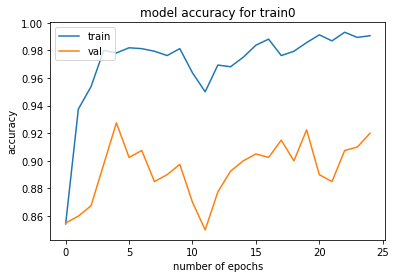

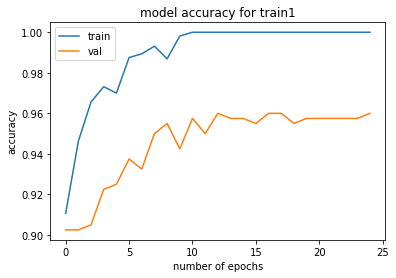

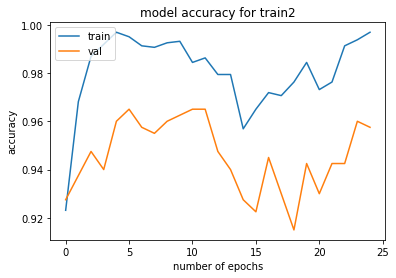

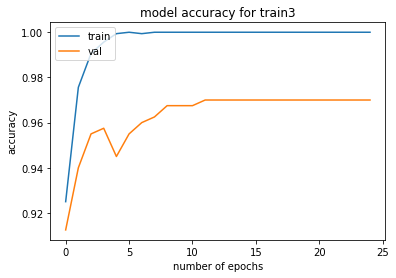

In [ ]:
for i in range(4):
  plt.plot(trhist[i])
  plt.plot(vlhist[i])
  plt.title('model accuracy for train%d' % i)
  plt.ylabel('accuracy')
  plt.xlabel('number of epochs')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

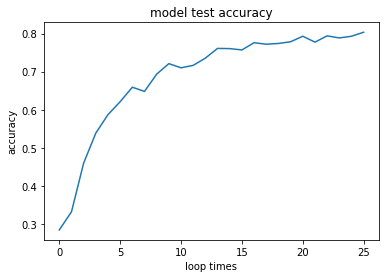

In [ ]:
plt.plot(test_acc)
plt.title('model test accuracy')
plt.ylabel('accuracy')
plt.xlabel('loop times')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, test_pred)

array([[162,   6,   4,   9,   0,   5,   3,   3,   7,   1],
       [  5, 154,   2,   9,  12,  15,   0,   1,   2,   0],
       [  2,  11, 159,   4,   2,   0,  12,   1,   5,   4],
       [  7,  18,   1, 143,   0,   1,   2,  16,   4,   8],
       [  0,   9,   5,   6, 106,  18,   7,  25,   8,  16],
       [  4,   9,   0,  12,   1, 164,   3,   3,   2,   2],
       [  4,   1,   5,   6,   0,   0, 172,  11,   0,   1],
       [  5,   2,   0,   1,   0,   0,   2, 190,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0, 194,   5],
       [  1,   2,   0,   0,   0,   0,   0,   1,   3, 193]])